# UMAP: What is it and how cuML helps

[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful, non-linear dimensionality reduction tool which NVIDIA recently ported to GPUs. Besides dimensionality reduction it can be used for powerful dataset visualizations, which is what we will use if for.

In this notebook we will demostrate basic usage, plotting, and timing of the unsupervised cuML version of UMAP. We will compare the visual results to t-sne and also the runtime characteristics to UMAP-learn.

## Imports and Set Up

Lets begin by importing our needed libraries

In [1]:
import os
import numpy as np

# libraries for scoring/clustering
from cuml.metrics import trustworthiness

#CPU UMAP
import umap

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

Lets try to ignore some warnings irrelevant to the tutorial

In [2]:
# hide warnings
import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=NumbaWarning) 

## Sanity Checks

It is a good practice to check for the needed files or hardware before spending time processing things.

We are going to work with 2 MNIST datasets: digits and fashion.  This datasets consisting of 70,000 28x28 grayscale images of clothing and handwritten digits.  They should already be in the `data` folder, but let's check:

In [3]:
if not os.path.exists('../../../data/fashion') and not os.path.exists('../../../data/digits'):
    print("error, data is missing!")

Now let's make sure we have our RAPIDS compliant GPU.  It must be Pascal or higher, that means 10 series, 20 series or a Quadro Pascal, Volta or Turing card.  You can also use this to define which GPU RAPIDS should use (advanced feature not covered here)

In [4]:
!nvidia-smi

Wed Jan 22 22:36:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:15:00.0 Off |                  Off |
| 29%   40C    P2    26W / 250W |  28119MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:2D:00.0  On |                  Off |
| 33%   46C    P0    29W / 250W |    284MiB / 32470MiB |     23%      Default |
+-------------------------------+----------------------+----------------------+
        

The above output also tells you information about utilization of the GPUs, so if you have been following the tutorials you probably see processes from the other notebooks, we **highly** recommend stopping those notebooks to free up resources!

## Example of UMAP for MNIST digits dataset

### Helper function to load data

We have provided a nice utility function to quickly load the MNIST datasets:

In [5]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Lets load the data:

In [6]:
train, train_labels = load_mnist('../../../data/digits', kind='train')
test, test_labels = load_mnist('../../../data/digits', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64)
target = np.array(np.hstack([train_labels, test_labels]))

We have 784 images, we can see how our dataset looks like:

In [7]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

Lets see how a single image looks:

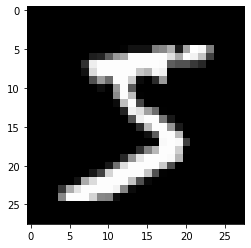

In [8]:
# display a 5
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

One algorithm that has been used in the past to succesfully visualize this dataset it t-sne:

![title](img/digitstsne.png)

The above graph was generated with a beta version of cuML's t-sne implementation (see https://github.com/rapidsai/cuml/pull/682). It manages to separate the digits pretty cleanly so it works well as a baseline case to see how UMAP behaves now!

First lets use the CPU based UMAP-learn, **note that it might take more than a minute to process**:

In [9]:
%%time
# CPU UMAP: using umap-learn package
cpu_umap = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)

CPU times: user 1min 10s, sys: 13.4 s, total: 1min 24s
Wall time: 58.6 s


Note that instead of creating the class first, then using `fit` to train the model and then `transform` to transform the data to reduce the dimensionality, we did that in a single line. 

The relevant parameters used for the algorithm are: 

```
n_neighbors:  number of neighboring points used in local approximations of manifold structure. It controls how well high level details are conserved against low level details of the geometric structure of the data. Values of 5 to 20 are typical.

init: Strategy to choose the initial embedding to start the algorithm in, `spectral` usually will lead to better results but is newer than `random`.
```

Now lets try the cuML GPU version. 

**NOTE: cuML 0.8 UMAP accepts either NumPy or cuDF dataframes only due to a bug (that has been fixed in nightly builds)**

Lets create our cuDF DataFrame:

In [11]:
data_df = cudf.DataFrame()
for i in range(data.shape[1]):
    data_df['fea%d'%i] = data[:,i]

Now call cuML:

In [12]:
%%time
gpu_umap = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(data_df)

CPU times: user 2.55 s, sys: 760 ms, total: 3.31 s
Wall time: 3.32 s


Now lets visualize the results! First lets name the classes appropriately:

In [13]:
classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

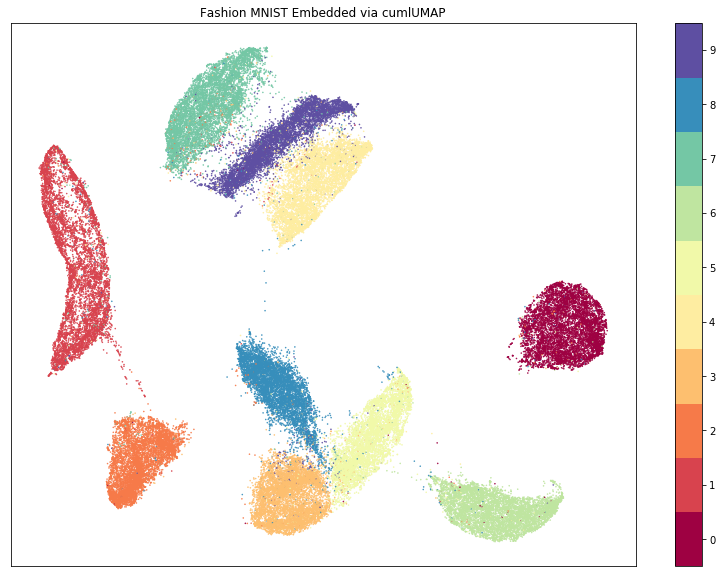

In [14]:
g_embedding_numpy = gpu_umap.as_matrix() #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

## Exercise: Use UMAP to visualize the Fashion MNIST dataset

Now lets see how t-sne behaves with the fashion dataset:

![title](img/fashiontsne.png)

As can be seen, the result here is not as clean as for the digits dataset. Therefore lets use UMAP to see if we can improve this.

Lets load our data:

In [15]:
train, train_labels = load_mnist('../../../data/fashion', kind='train')
test, test_labels = load_mnist('../../../data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255
target = np.array(np.hstack([train_labels, test_labels]))

There are 60000 training images and 10000 test images

In [16]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

As mentioned previously, each row in the train matrix is an image

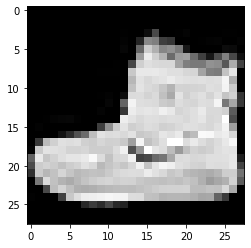

In [17]:
# display a sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

**Now its your turn to train the UMAP models:**

## Visualization

OK, now let's plot the output of the embeddings so that we can see the seperation of the neighborhoods.  Let's start by creating the classes:

In [18]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

**Now its your turn to visualize the dataset in a similar manner to the digits one**

Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py#L395).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention. Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

In [ ]:
# Note: sklearn trustworthiness calculation can run out of memory in the instance!
# trust = trustworthiness(data, cpu_umap)

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation!!